In [1]:
import pandas as pd
import numpy as np
import os
import glob
import json
weathers = ['windspeedKmph', 'winddirDegree', 'weatherCode', 'precipMM',
            'visibilty', 'pressure', 'cloudcover', 'DewPointF',
            'WindGustKmph', 'tempF', 'WindChillF',	'humidity',
            'date',	'time',	'airport']
weather_df = pd.DataFrame(columns = weathers)
flights = ['FlightDate', 'Quarter',	'Year',	'Month',
            'DayofMonth', 'DepTime', 'DepDel15', 'CRSDepTime',
            'DepDelayMinutes', 'OriginAirportID', 'DestAirportID', 'ArrTime',
            'CRSArrTime', 'ArrDel15', 'ArrDelayMinutes','Origin', 'Dest'] 
flight_df = pd.DataFrame(columns = flights)

In [2]:
main_folder_path_1 = '2016 & 2017'

valid_airports = ['ATL', 'CLT', 'DEN', 'DFW', 'EWR',
                  'IAH', 'JFK', 'LAS', 'LAX', 'MCO',
                  'MIA', 'ORD', 'PHX', 'SEA', 'SFO']

dataframes = []

for root, dirs, files in os.walk(main_folder_path_1):
    for filename in files:
        if filename.endswith('.csv'): 
            file_path = os.path.join(root, filename)
            df = pd.read_csv(file_path, usecols=[
                'FlightDate', 'Quarter', 'Year', 'Month', 'DayofMonth',
                'DepTime', 'DepDel15', 'CRSDepTime', 'DepDelayMinutes',
                'OriginAirportID', 'DestAirportID', 'ArrTime',
                'CRSArrTime', 'ArrDel15', 'ArrDelayMinutes', 'Origin', 'Dest'
            ])
            
            filtered_df = df[(df['Origin'].isin(valid_airports)) & (df['Dest'].isin(valid_airports))]
            
            dataframes.append(filtered_df)

flights_df = pd.concat(dataframes, axis=0, ignore_index=True)

flights_df.head()

,Year,Quarter,Month,DayofMonth,FlightDate,OriginAirportID,Origin,DestAirportID,Dest,CRSDepTime,DepTime,DepDelayMinutes,DepDel15,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15
0,2016,1,1,1,2016-01-01,14747,SEA,12478,JFK,745,741.0,0.0,0.0,1602,1610.0,8.0,0.0
1,2016,1,1,2,2016-01-02,14747,SEA,12478,JFK,745,737.0,0.0,0.0,1602,1613.0,11.0,0.0
2,2016,1,1,3,2016-01-03,14747,SEA,12478,JFK,745,743.0,0.0,0.0,1602,1547.0,0.0,0.0
3,2016,1,1,4,2016-01-04,14747,SEA,12478,JFK,745,737.0,0.0,0.0,1602,1551.0,0.0,0.0
4,2016,1,1,5,2016-01-05,14747,SEA,12478,JFK,710,708.0,0.0,0.0,1527,1524.0,0.0,0.0


In [3]:
flights_df.tail()

,Year,Quarter,Month,DayofMonth,FlightDate,OriginAirportID,Origin,DestAirportID,Dest,CRSDepTime,DepTime,DepDelayMinutes,DepDel15,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15
1877291,2017,3,9,25,2017-09-25,14771,SFO,12478,JFK,2045,2038.0,0.0,0.0,522,449.0,0.0,0.0
1877292,2017,3,9,25,2017-09-25,11618,EWR,13204,MCO,1205,1200.0,0.0,0.0,1449,1428.0,0.0,0.0
1877293,2017,3,9,25,2017-09-25,13204,MCO,11618,EWR,1141,1143.0,2.0,0.0,1417,1409.0,0.0,0.0
1877294,2017,3,9,25,2017-09-25,12889,LAS,12478,JFK,2159,2157.0,0.0,0.0,557,540.0,0.0,0.0
1877295,2017,3,9,25,2017-09-25,13204,MCO,12478,JFK,605,605.0,0.0,0.0,837,821.0,0.0,0.0


In [4]:
flights_df.shape

(1877296, 17)

In [5]:
weather_folder_path = 'weather'
normalized_folder_path = 'normalized_weather'

if not os.path.exists(normalized_folder_path):
    os.makedirs(normalized_folder_path)

dataframes = []

for root, dirs, files in os.walk(weather_folder_path):
    for file_name in files:
        if file_name.endswith('.json') and ('2016' in file_name or '2017' in file_name):
            file_path = os.path.join(root, file_name)
            
            print(f"Processing file: {file_path}")
            
            airport_name = os.path.basename(root)
            normalized_file_path = os.path.join(normalized_folder_path, f"{airport_name}_{file_name.replace('.json', '.csv')}")
            
            if os.path.exists(normalized_file_path):
                print(f"File already normalized: {normalized_file_path}")
                df = pd.read_csv(normalized_file_path)
                dataframes.append(df)
                continue
            
            try:
                with open(file_path) as f:
                    data = json.load(f)
                
                all_hourly_data = []
                for day in data['data']['weather']:
                    date = day['date']
                    hourly_data = pd.json_normalize(day, 'hourly')
                    hourly_data['date'] = date
                    hourly_data['airport'] = airport_name
                    
                    hourly_data.columns = [col.lower() for col in hourly_data.columns]
                    columns_to_keep = {
                        'windspeedkmph': 'WindSpeedKmph', 'winddirdegree': 'WindDirDegree',
                        'weathercode': 'WeatherCode', 'precipmm': 'precipMM',
                        'visibility': 'Visibility', 'pressure': 'Pressure',
                        'cloudcover': 'Cloudcover', 'dewpointf': 'DewPointF',
                        'windgustkmph': 'WindGustKmph', 'tempf': 'tempF',
                        'windchillf': 'WindChillF', 'humidity': 'Humidity',
                        'date': 'date', 'time': 'time', 'airport': 'airport'
                    }
                    hourly_data = hourly_data.rename(columns=columns_to_keep)
                    hourly_data = hourly_data[list(columns_to_keep.values())]
                    
                    all_hourly_data.append(hourly_data)
                
                combined_hourly_data = pd.concat(all_hourly_data, ignore_index=True)
                
                combined_hourly_data.to_csv(normalized_file_path, index=False)
                print(f"Successfully saved normalized data to: {normalized_file_path}")
                
                dataframes.append(combined_hourly_data)
            
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")

weather_df = pd.concat(dataframes, ignore_index=True)

print("Combined Weather DataFrame:")
weather_df.head()

Processing file: weather\ATL\2016-1.json
File already normalized: normalized_weather\ATL_2016-1.csv
Processing file: weather\ATL\2016-10.json
File already normalized: normalized_weather\ATL_2016-10.csv
Processing file: weather\ATL\2016-11.json
File already normalized: normalized_weather\ATL_2016-11.csv
Processing file: weather\ATL\2016-12.json
File already normalized: normalized_weather\ATL_2016-12.csv
Processing file: weather\ATL\2016-2.json
File already normalized: normalized_weather\ATL_2016-2.csv
Processing file: weather\ATL\2016-3.json
File already normalized: normalized_weather\ATL_2016-3.csv
Processing file: weather\ATL\2016-4.json
File already normalized: normalized_weather\ATL_2016-4.csv
Processing file: weather\ATL\2016-5.json
File already normalized: normalized_weather\ATL_2016-5.csv
Processing file: weather\ATL\2016-6.json
File already normalized: normalized_weather\ATL_2016-6.csv
Processing file: weather\ATL\2016-7.json
File already normalized: normalized_weather\ATL_2016-

,WindSpeedKmph,WindDirDegree,WeatherCode,precipMM,Visibility,Pressure,Cloudcover,DewPointF,WindGustKmph,tempF,WindChillF,Humidity,date,time,airport
0,11,318,176,0.1,10,1023,100,47,17,49,46,91,2016-01-01,0,ATL
1,13,317,176,0.0,10,1023,100,44,22,46,42,92,2016-01-01,100,ATL
2,14,315,122,0.0,10,1023,100,41,26,43,38,92,2016-01-01,200,ATL
3,16,314,122,0.0,10,1023,100,38,30,40,33,93,2016-01-01,300,ATL
4,17,314,122,0.0,10,1023,100,38,30,40,33,93,2016-01-01,400,ATL


In [6]:
weather_df.tail()

,WindSpeedKmph,WindDirDegree,WeatherCode,precipMM,Visibility,Pressure,Cloudcover,DewPointF,WindGustKmph,tempF,WindChillF,Humidity,date,time,airport
263155,26,296,113,0.0,10,1014,0,57,27,67,67,70,2017-09-30,1900,SFO
263156,26,298,113,0.0,10,1014,0,58,27,67,67,71,2017-09-30,2000,SFO
263157,26,300,113,0.0,10,1014,0,58,27,67,67,73,2017-09-30,2100,SFO
263158,23,302,113,0.0,10,1014,0,58,25,66,66,74,2017-09-30,2200,SFO
263159,20,303,113,0.0,10,1014,0,58,22,66,66,75,2017-09-30,2300,SFO


In [7]:
weather_df.shape

(263160, 15)

In [8]:
flights_df['ArrTime'].dtype

dtype('float64')

In [9]:
weather_df['time'].dtype

dtype('int64')

In [10]:
weather_df['date'] = pd.to_datetime(weather_df['date']).dt.strftime('%Y-%m-%d')
flights_df['FlightDate'] = pd.to_datetime(flights_df['FlightDate']).dt.strftime('%Y-%m-%d')

weather_df.head()
flights_df.head()

,Year,Quarter,Month,DayofMonth,FlightDate,OriginAirportID,Origin,DestAirportID,Dest,CRSDepTime,DepTime,DepDelayMinutes,DepDel15,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15
0,2016,1,1,1,2016-01-01,14747,SEA,12478,JFK,745,741.0,0.0,0.0,1602,1610.0,8.0,0.0
1,2016,1,1,2,2016-01-02,14747,SEA,12478,JFK,745,737.0,0.0,0.0,1602,1613.0,11.0,0.0
2,2016,1,1,3,2016-01-03,14747,SEA,12478,JFK,745,743.0,0.0,0.0,1602,1547.0,0.0,0.0
3,2016,1,1,4,2016-01-04,14747,SEA,12478,JFK,745,737.0,0.0,0.0,1602,1551.0,0.0,0.0
4,2016,1,1,5,2016-01-05,14747,SEA,12478,JFK,710,708.0,0.0,0.0,1527,1524.0,0.0,0.0


In [11]:
weather_df.tail()
flights_df.tail()

,Year,Quarter,Month,DayofMonth,FlightDate,OriginAirportID,Origin,DestAirportID,Dest,CRSDepTime,DepTime,DepDelayMinutes,DepDel15,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15
1877291,2017,3,9,25,2017-09-25,14771,SFO,12478,JFK,2045,2038.0,0.0,0.0,522,449.0,0.0,0.0
1877292,2017,3,9,25,2017-09-25,11618,EWR,13204,MCO,1205,1200.0,0.0,0.0,1449,1428.0,0.0,0.0
1877293,2017,3,9,25,2017-09-25,13204,MCO,11618,EWR,1141,1143.0,2.0,0.0,1417,1409.0,0.0,0.0
1877294,2017,3,9,25,2017-09-25,12889,LAS,12478,JFK,2159,2157.0,0.0,0.0,557,540.0,0.0,0.0
1877295,2017,3,9,25,2017-09-25,13204,MCO,12478,JFK,605,605.0,0.0,0.0,837,821.0,0.0,0.0


In [12]:
print(weather_df.isnull().sum())

WindSpeedKmph    0
WindDirDegree    0
WeatherCode      0
precipMM         0
Visibility       0
Pressure         0
Cloudcover       0
DewPointF        0
WindGustKmph     0
tempF            0
WindChillF       0
Humidity         0
date             0
time             0
airport          0
dtype: int64


In [13]:
print(flights_df.isnull().sum())

Year                   0
Quarter                0
Month                  0
DayofMonth             0
FlightDate             0
OriginAirportID        0
Origin                 0
DestAirportID          0
Dest                   0
CRSDepTime             0
DepTime            20980
DepDelayMinutes    20987
DepDel15           20987
CRSArrTime             0
ArrTime            22080
ArrDelayMinutes    25860
ArrDel15           25860
dtype: int64


In [14]:
flights_df = flights_df.dropna()

In [15]:
print(flights_df.isnull().sum())

Year               0
Quarter            0
Month              0
DayofMonth         0
FlightDate         0
OriginAirportID    0
Origin             0
DestAirportID      0
Dest               0
CRSDepTime         0
DepTime            0
DepDelayMinutes    0
DepDel15           0
CRSArrTime         0
ArrTime            0
ArrDelayMinutes    0
ArrDel15           0
dtype: int64


In [16]:
flights_df['ArrTime'] = flights_df['ArrTime'].astype(int)

In [17]:
flights_df['ArrTime'].dtype

dtype('int64')

In [18]:
weather_df['time'].dtype

dtype('int64')

In [19]:
flights_df['ArrDelayMinutes'].dtype

dtype('float64')

In [20]:
flights_df['ArrDelayMinutes'] = flights_df['ArrDelayMinutes'].astype(int)

In [21]:
flights_df.head()

,Year,Quarter,Month,DayofMonth,FlightDate,OriginAirportID,Origin,DestAirportID,Dest,CRSDepTime,DepTime,DepDelayMinutes,DepDel15,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15
0,2016,1,1,1,2016-01-01,14747,SEA,12478,JFK,745,741.0,0.0,0.0,1602,1610,8,0.0
1,2016,1,1,2,2016-01-02,14747,SEA,12478,JFK,745,737.0,0.0,0.0,1602,1613,11,0.0
2,2016,1,1,3,2016-01-03,14747,SEA,12478,JFK,745,743.0,0.0,0.0,1602,1547,0,0.0
3,2016,1,1,4,2016-01-04,14747,SEA,12478,JFK,745,737.0,0.0,0.0,1602,1551,0,0.0
4,2016,1,1,5,2016-01-05,14747,SEA,12478,JFK,710,708.0,0.0,0.0,1527,1524,0,0.0


In [22]:
flights_df['Dest'].dtype

dtype('O')

In [23]:
def round_to_nearest_hour(time):
    hours = time // 100 
    minutes = time % 100 
    if minutes >= 30:
        hours += 1
    elif hours == 0:
        return 0
    return hours * 100

flights_df['rounded_time'] = flights_df['CRSArrTime'].apply(round_to_nearest_hour)

In [24]:
flights_df.head()

,Year,Quarter,Month,DayofMonth,FlightDate,OriginAirportID,Origin,DestAirportID,Dest,CRSDepTime,DepTime,DepDelayMinutes,DepDel15,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,rounded_time
0,2016,1,1,1,2016-01-01,14747,SEA,12478,JFK,745,741.0,0.0,0.0,1602,1610,8,0.0,1600
1,2016,1,1,2,2016-01-02,14747,SEA,12478,JFK,745,737.0,0.0,0.0,1602,1613,11,0.0,1600
2,2016,1,1,3,2016-01-03,14747,SEA,12478,JFK,745,743.0,0.0,0.0,1602,1547,0,0.0,1600
3,2016,1,1,4,2016-01-04,14747,SEA,12478,JFK,745,737.0,0.0,0.0,1602,1551,0,0.0,1600
4,2016,1,1,5,2016-01-05,14747,SEA,12478,JFK,710,708.0,0.0,0.0,1527,1524,0,0.0,1500


In [25]:
flights_df.shape

(1851436, 18)

In [26]:
weather_df.shape

(263160, 15)

In [27]:
weather_df['airport'].dtype

dtype('O')

In [28]:
merged_df = pd.merge(flights_df, weather_df,
                     left_on=['FlightDate', 'rounded_time', 'Dest'], 
                     right_on=['date', 'time', 'airport'], 
                     how='left')
merged_df = merged_df.drop(columns=['date', 'time', 'airport'])

In [29]:
print(merged_df.isnull().sum())

Year                   0
Quarter                0
Month                  0
DayofMonth             0
FlightDate             0
OriginAirportID        0
Origin                 0
DestAirportID          0
Dest                   0
CRSDepTime             0
DepTime                0
DepDelayMinutes        0
DepDel15               0
CRSArrTime             0
ArrTime                0
ArrDelayMinutes        0
ArrDel15               0
rounded_time           0
WindSpeedKmph      51490
WindDirDegree      51490
WeatherCode        51490
precipMM           51490
Visibility         51490
Pressure           51490
Cloudcover         51490
DewPointF          51490
WindGustKmph       51490
tempF              51490
WindChillF         51490
Humidity           51490
dtype: int64


In [30]:
merged_df = merged_df.fillna(0)

In [31]:
print(merged_df.isnull().sum())

Year               0
Quarter            0
Month              0
DayofMonth         0
FlightDate         0
OriginAirportID    0
Origin             0
DestAirportID      0
Dest               0
CRSDepTime         0
DepTime            0
DepDelayMinutes    0
DepDel15           0
CRSArrTime         0
ArrTime            0
ArrDelayMinutes    0
ArrDel15           0
rounded_time       0
WindSpeedKmph      0
WindDirDegree      0
WeatherCode        0
precipMM           0
Visibility         0
Pressure           0
Cloudcover         0
DewPointF          0
WindGustKmph       0
tempF              0
WindChillF         0
Humidity           0
dtype: int64


In [32]:
merged_df.head()

,Year,Quarter,Month,DayofMonth,FlightDate,OriginAirportID,Origin,DestAirportID,Dest,CRSDepTime,...,WeatherCode,precipMM,Visibility,Pressure,Cloudcover,DewPointF,WindGustKmph,tempF,WindChillF,Humidity
0,2016,1,1,1,2016-01-01,14747,SEA,12478,JFK,745,...,113.0,0.0,10.0,1015.0,0.0,32.0,26.0,41.0,32.0,74.0
1,2016,1,1,2,2016-01-02,14747,SEA,12478,JFK,745,...,113.0,0.0,10.0,1016.0,0.0,30.0,23.0,39.0,31.0,71.0
2,2016,1,1,3,2016-01-03,14747,SEA,12478,JFK,745,...,113.0,0.0,10.0,1009.0,46.0,31.0,28.0,40.0,32.0,69.0
3,2016,1,1,4,2016-01-04,14747,SEA,12478,JFK,745,...,116.0,0.0,10.0,1019.0,22.0,15.0,34.0,26.0,11.0,65.0
4,2016,1,1,5,2016-01-05,14747,SEA,12478,JFK,710,...,113.0,0.0,10.0,1035.0,0.0,14.0,19.0,27.0,15.0,61.0


In [33]:
merged_df.tail()

,Year,Quarter,Month,DayofMonth,FlightDate,OriginAirportID,Origin,DestAirportID,Dest,CRSDepTime,...,WeatherCode,precipMM,Visibility,Pressure,Cloudcover,DewPointF,WindGustKmph,tempF,WindChillF,Humidity
1851431,2017,3,9,25,2017-09-25,14771,SFO,12478,JFK,2045,...,143.0,0.0,10.0,1017.0,70.0,69.0,6.0,70.0,70.0,97.0
1851432,2017,3,9,25,2017-09-25,11618,EWR,13204,MCO,1205,...,113.0,0.0,10.0,1011.0,1.0,72.0,12.0,91.0,91.0,54.0
1851433,2017,3,9,25,2017-09-25,13204,MCO,11618,EWR,1141,...,113.0,0.0,10.0,1017.0,11.0,67.0,11.0,84.0,84.0,58.0
1851434,2017,3,9,25,2017-09-25,12889,LAS,12478,JFK,2159,...,143.0,0.0,10.0,1017.0,88.0,67.0,6.0,68.0,68.0,98.0
1851435,2017,3,9,25,2017-09-25,13204,MCO,12478,JFK,605,...,116.0,0.0,10.0,1018.0,55.0,66.0,8.0,70.0,70.0,90.0


In [34]:
merged_df.shape

(1851436, 30)

In [35]:
print(merged_df.dtypes)

Year                 int64
Quarter              int64
Month                int64
DayofMonth           int64
FlightDate          object
OriginAirportID      int64
Origin              object
DestAirportID        int64
Dest                object
CRSDepTime           int64
DepTime            float64
DepDelayMinutes    float64
DepDel15           float64
CRSArrTime           int64
ArrTime              int64
ArrDelayMinutes      int64
ArrDel15           float64
rounded_time         int64
WindSpeedKmph      float64
WindDirDegree      float64
WeatherCode        float64
precipMM           float64
Visibility         float64
Pressure           float64
Cloudcover         float64
DewPointF          float64
WindGustKmph       float64
tempF              float64
WindChillF         float64
Humidity           float64
dtype: object


In [36]:
merged_df.to_csv("Preprocessed_Data.csv", index=False)

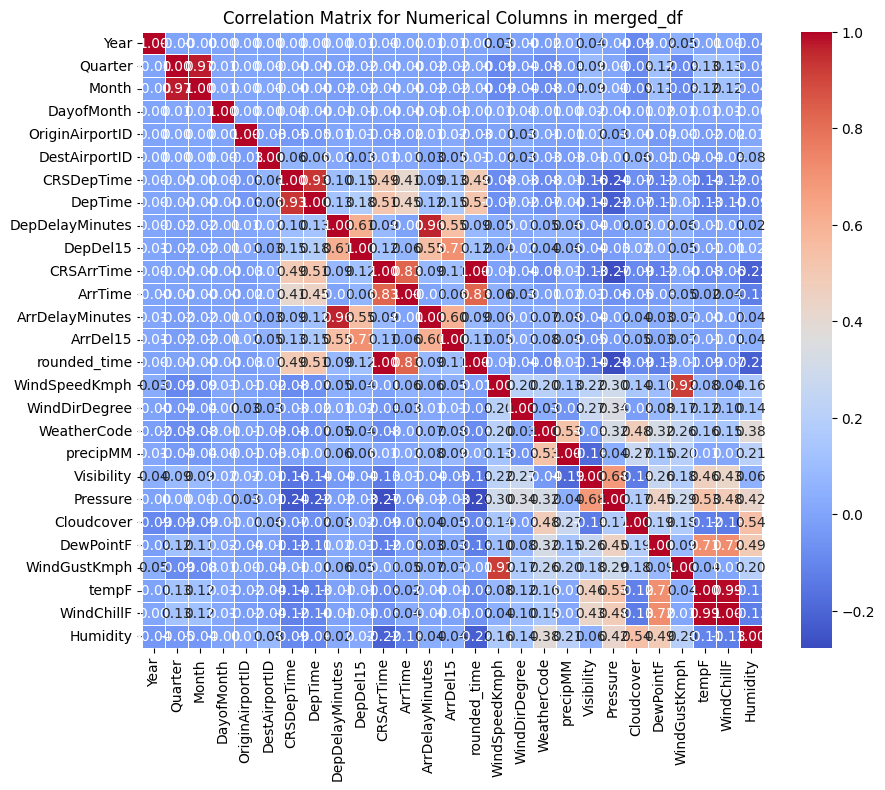

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = merged_df.select_dtypes(include=['number']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix for Numerical Columns in merged_df')
plt.show()